## Excercises on ice sheet modeling at GIA summerschool 2023
© Torsten Albrecht, albrecht@pik-potsdam.de, PIK, 2023

- code snippets are based on [PISM](https://www.pism.io), pism/examples/mismip/mismip2d

### 3 Marine ice sheet instability

There is a whole theory on MISI since 50 years ([Weertman 1974](https://doi.org/10.3189/S0022143000023327)), in particular for unbuttressed ice sheets and ice shelves. [Schoof 2007](https://doi.org/10.1029/2006JF000664) came up with a semianalytical solution for the variational problem, with the flux at the grounding line

$$
Q(x_g) \propto H(x_g)^{4.75}
$$



Consider a marine ice sheet resting on an overdeepende bed (typical for West Antarctic Ice Sheet):

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

import matplotlib.pylab as plt
from matplotlib import cm, colors
import netCDF4 as nc
import numpy as np

In [2]:
# following pism/examples/mismip/mismip2d

# ice softness
A3b4 = 5.0e-26
#A3b4 = 1.0e-26

#sliding coefficient
Csl = 7.624e6

rhoi = 900.0
rhosw = 1000.0

spa = 60*60*365.25*24 # s per year

#mode 2
N = 1500

# length
Lm = 1800e3
x = np.linspace(-Lm, Lm, 2 * N + 1)

# convert x to kilometers
xkm = x/1e3

#calving_front
xcf = 1750e3

def bed(x):
    #"Bed depth below sea level. (-b(x) = topg(x))"
    xx = x / 7.5e5
    return -(729. - 2184.8 * xx ** 2. + 1031.72 * xx ** 4. - 151.72 * xx ** 6.)

def M():
    #"Accumulation rate (m/s)"
    return 0.3 / spa

def b_slope(x):
    #"""The x-derivative of b(experiment, x)."""
    xx = x / 7.5e5
    return -(- 2184.8 * (2. / 7.5e5) * xx
             + 1031.72 * (4. / 7.5e5) * xx ** 3.
             - 151.72 * (6. / 7.5e5) * xx ** 5.)

def g():
    #"""Acceleration due to gravity. (Table 2 on page 19 of mismip_4.pdf
    #uses this value, i.e. g = 9.8 m s-2.)"""
    return 9.81

def m():
    #"Sliding law exponent"
    return 1 / 3.0
    #return 1.0

def n():
    #"Glen exponent"
    return 3.0


def cold_function(x, sl, A0 , theta=0.0):
    """Evaluates function whose zeros define x_g in 'cold' steady marine sheet problem."""
    r = rhoi / rhosw
    h_f = r ** (-1.) * (bed(x)+sl)
    b_x = b_slope(x)
    s = M() * x
    rho_g = rhoi * g()
    return (theta * M()
            + Csl * s ** (m() + 1.0) / (rho_g * h_f ** (m() + 2.))
            - theta * s * b_x / h_f
            - A0 * (rho_g * (1.0 - r) / 4.0) ** n() * h_f ** (n() + 1.0))


def x_g(sl, xi, A0, theta=0.0):
    """Computes the theoretical grounding line location using Newton's method."""

    # set the initial guess
    x = xi*1e3 #m

    delta_x = 10.  # Finite difference step size (metres) for gradient calculation
    tolf = 1.e-4  # Tolerance for finding zeros
    eps = np.finfo(float).eps
    normf = tolf + eps
    toldelta = 1.e1                     # Newton step size tolerance
    dx = toldelta + 1.0

    # this is just a shortcut
    def F(x):
        return cold_function(x, sl, A0, theta)

    while (normf > tolf) or (abs(dx) > toldelta):
        f = F(x)
        normf = abs(f)
        grad = (F(x + delta_x) - f) / delta_x
        dx = -f / grad
        x = x + dx

    return x


def thickness(sl, x, xi, A0, theta=0.0):
    #"""Compute ice thickness for x > 0.
    #"""
    # compute the grounding line position
    xg = x_g(sl, xi, A0, theta)

    def surface(h, x):
        b_x = b_slope(x)
        rho_g = rhoi * g()
        s = M() * np.abs(x)
        return b_x - (Csl / rho_g) * s ** m() / h ** (m() + 1)

    # extract the grounded part of the grid
    x_grounded = x[x < xg]

    # We will integrate from the grounding line inland. odeint requires that
    # the first point in x_grid be the one corresponding to the initial
    # condition; append it and reverse the order.
    x_grid = np.append(xg, x_grounded[::-1])

    # use thickness at the grounding line as the initial condition
    h_f = bed(xg) * rhosw / rhoi

    import scipy.integrate
    thk_grounded = scipy.integrate.odeint(surface, [h_f], x_grid, atol=1.e-9, rtol=1.e-9)

    # now 'result' contains thickness in reverse order, including the grounding
    # line point (which is not on the grid); discard it and reverse the order.
    thk_grounded = np.squeeze(thk_grounded)[:0:-1]

    # extract the floating part of the grid
    x_floating = x[x >= xg]

    # compute the flux through the grounding line
    q_0 = M() * xg

    # Calculate ice thickness for shelf from van der Veen (1986)
    r = rhoi / rhosw
    rho_g = rhoi * g()
    numer = h_f * (q_0 + M() * (x_floating - xg))
    base = q_0 ** (n() + 1) + h_f ** (n() + 1) * ((1 - r) * rho_g / 4) ** n() * A0 \
        * ((q_0 + M() * (x_floating - xg)) ** (n() + 1) - q_0 ** (n() + 1)) / M()
    thk_floating = numer / (base ** (1.0 / (n() + 1)))

    x_nonnegative = x[x >= 0]
    thk_nonnegative = np.r_[thk_grounded, thk_floating]
    thk_nonnegative = thk_nonnegative[x >= 0]
    thk_nonnegative[x_nonnegative > xcf] = 0
    
    thk = np.zeros_like(x)
    thk[x >= 0] = thk_nonnegative
    thk[x < 0] = thk_nonnegative[:0:-1]
    
    return thk



x_g: 1412.2 km


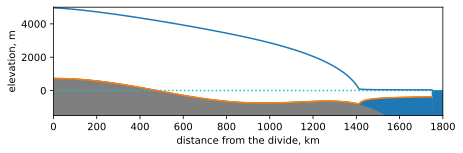

In [3]:

def plot_mismip2d(topg,thk):

    # grounded / floating mask
    mask = np.ones_like(topg)*2 #grounded
    mask[-rhoi/rhosw*thk>topg]=3 # floating
    mask[thk==0]=4 # ice free ocean

    # surface elevation
    usurf = topg + thk
    usurf[mask>=3] = (1.0-rhoi/rhosw) * thk[mask>=3]
    usurf = np.ma.array(usurf, mask=mask == 4)

    # sub surface elevation
    lsurf = topg.copy()
    lsurf[mask == 3] = -rhoi / rhosw * thk[mask == 3]
    lsurf = np.ma.array(lsurf, mask=mask == 4)

    #######################################


    fig = plt.figure(12,figsize=(7,2))
    ax = fig.add_subplot(1,1,1)

    # sea level 0
    ax.plot(xkm, np.zeros_like(xkm), ls='dotted', color='C9')
    ax.plot(xkm, usurf, color='C0')

    # bedrock
    #ax.plot(xkm, topg, color='black')
    ax.fill_between(xkm,-1500,topg,color='C7')

    # ocean water
    ax.plot(xkm, lsurf, color='C1')
    ax.fill_between(xkm,topg,lsurf,color='C0')
    ax.fill_between(xkm[ ((mask==4) & (xkm<0)) ],topg[ ((mask==4) & (xkm<0)) ],0,color='C0')
    ax.fill_between(xkm[ ((mask==4) & (xkm>0)) ],topg[ ((mask==4) & (xkm>0)) ],0,color='C0')

    ax.set_xlabel('distance from the divide, km')
    ax.set_ylabel('elevation, m')

    #_, _, ymin, ymax = ax.axis(xmin=xkm.min(), xmax=xkm.max())
    _, _, ymin, ymax = ax.axis(xmin=0.0, xmax=xkm.max())
    ax.set_ylim(-1500,5000)

####################################################
    
sl = 0.0
xi = 1370.0

topg = -bed(x)-sl
thk = thickness(sl, x, xi, A3b4 , theta=0.0)
    
print('x_g:',np.around(x_g(sl, xi, A3b4 , theta=0.0)*1e-3,decimals=1),'km')

plot_mismip2d(topg,thk)


This marine ice sheet system is multistable, so if you select a different initial quess for $x_i$ you end up in a different state.

x_g: 923.1 km


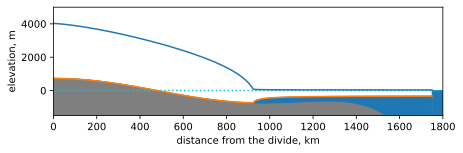

In [4]:
sl = 0.0
xi = 900.0

topg = -bed(x)-sl
thk = thickness(sl, x, xi, A3b4 , theta=0.0)
    
print('x_g:',np.around(x_g(sl, xi, A3b4 , theta=0.0)*1e-3,decimals=1),'km')

plot_mismip2d(topg,thk)


#### Q3: What (global mean) sea-level rise would ne required to initiate a MISI?

Hint: You may adjust the initial quess $x_i$ to achieve convergence to a solution...

<div class="alert alert-block alert-info">
<details>
<summary><b>A3:</b> click to show solution</summary>

In this case a sea level rise above $160\text{m}$ would trigger the marine ice sheet sdystem to tip into a different state.
</details>
</div>

In [5]:
for sl in range(0,200,10):
 
    xi=1370.0
    topg = -bed(x)-sl

    try:
        thk = thickness(sl, x, xi, A3b4 , theta=0.0)
        print('x_g:',sl,'m: ',np.around(x_g(sl, xi, A3b4 , theta=0.0)*1e-3,decimals=1),'km')
    except:
        print('For sl >'+str(sl)+' m there is no local minimum, adjust xi!')
    

x_g: 0 m:  1412.2 km
x_g: 10 m:  1408.6 km
x_g: 20 m:  1404.9 km
x_g: 30 m:  1401.0 km
x_g: 40 m:  1396.9 km
x_g: 50 m:  1392.5 km
x_g: 60 m:  1388.0 km
x_g: 70 m:  1383.1 km
x_g: 80 m:  1378.0 km
x_g: 90 m:  1372.4 km
x_g: 100 m:  1366.3 km
x_g: 110 m:  1359.7 km
x_g: 120 m:  1352.2 km
x_g: 130 m:  1343.6 km
x_g: 140 m:  1333.2 km
x_g: 150 m:  1319.8 km
x_g: 160 m:  1296.7 km
For sl >170 m there is no local minimum, adjust xi!
For sl >180 m there is no local minimum, adjust xi!
For sl >190 m there is no local minimum, adjust xi!


There was a model intercomparison ([Pattyn et al., 2012](https://doi.org/10.5194/tc-6-573-2012)), called MISMIP, showing hysteresis behavior for different ice softness parameter (isothermal).

For certain values of ice softness there is only one stable solution (instead of two). You can find the (in)stable grounding line positions, where the "Schoof" flux ([Schoof 2007](https://doi.org/10.1029/2006JF000664)) intersects with ice flux $M x$.

#### Q3b: At which ice softness the ice sheet would tip from a smaller state to to more extended one, and for which other way around?

<div class="alert alert-block alert-info">
<details>
<summary><b>A3b:</b> click to show solution</summary>

If ice cools (becoming harder, e.g $2.5 \times 10^{-26} Pa^{-3} s^{-1}$) this specific (unbuttressed) marine ice sheet may tip to to more extended state.
If the ice warms (becoming an order of magnitude softer) (e.g $2.5 \times 10^{-25} Pa^{-3} s^{-1}$) it may tip to a less extended state (MISI).
 
</details>
</div>

/tmp/ipykernel_17285/2793940455.py:32: RuntimeWarning: invalid value encountered in power
  qschoof *= h_gr**((m()+n()+3.0)/(m()+1.0)) * spa*1e-6
/tmp/ipykernel_17285/2922672300.py:67: RuntimeWarning: invalid value encountered in scalar power
  + Csl * s ** (m() + 1.0) / (rho_g * h_f ** (m() + 2.))


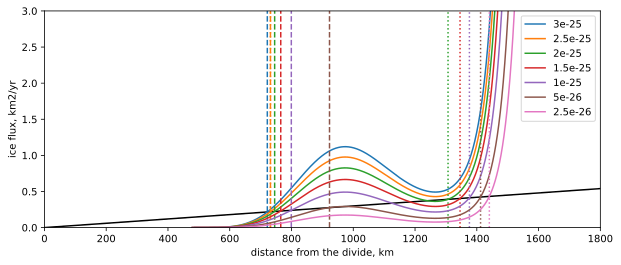

In [6]:
fig = plt.figure(13,figsize=(10,4))
ax = fig.add_subplot(1,1,1)

# ice flux uH = ax
qflux = M() * x  #* spa  m2/s
qflux_scale = qflux * spa*1e-6 #km2/yr

#thk = thickness(experiment, step, x(mode))[1]
#uvel = qflux / thk  #m/s

ax.plot(xkm, qflux_scale, color='k')

r = rhoi / rhosw
h_gr = r ** (-1.) * (-topg-sl)
rho_g = rhoi * g()

# Values of A to be used in MISMIP experiment 3a.
A3a = np.array([3.0e-25, 2.5e-25, 2.0e-25,
                    1.5e-25, 1.0e-25, 5.0e-26,
                    2.5e-26, 5.0e-26, 1.0e-25,
                    1.5e-25, 2.0e-25, 2.5e-25,
                    3.0e-25])


xi1=900.0
xi2=1370.0
sl=0.0

for s in range(0,7): 
    
    qschoof = (A3a[s] * (rho_g)**(n()+1.0) * (1.0 - r)**n() / (4.0**n() * Csl) )**(1.0/(m()+1.0)) 
    qschoof *= h_gr**((m()+n()+3.0)/(m()+1.0)) * spa*1e-6

    #######################################################

    ax.plot(xkm, qschoof,color="C"+str(s),label=str(A3a[s])) #color='C1'
    ax.axvline(x_g(sl, xi1, A3a[s])*1e-3,color="C"+str(s),ls='dashed')
    ax.axvline(x_g(sl, xi2, A3a[s])*1e-3,color="C"+str(s),ls='dotted')
  
ax.set_xlabel('distance from the divide, km')
ax.set_ylabel('ice flux, km2/yr')
_, _, ymin, ymax = ax.axis(xmin=0, xmax=xkm.max())
ax.set_ylim(0,3) #km2/yr
plt.legend()